In [1]:
!pip install --quiet opencv-python torch torchvision captum 

In [1]:
import sys
sys.path.insert(1, '../')
import helpers, os
from PIL import Image
import cv2, numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from helpers.attribution import convert_to_uint8

device = helpers.models.get_device()

In [2]:
def write_attribution(out_path, attr):
    cv2.imwrite(out_path,convert_to_uint8(attr))

def load_attribution(attr_path):
    return cv2.imread(attr_path)[:,:,0]

# Initialise Core Components

## Models

In [3]:
models_base_pth = "/home/local/data/sophie/padcxr14_models/step_decay_cxr14/arch_seg/"
full_config_path = "full_network/{}/lr_step_decay_10_epochs_0.1_rate/model_lr_0.0005_bsz_16_mom_0.99_seed_{}_pos-weight_1.0.pth/model_17.pth"

# load base models to cpu
base_full_model_1 = helpers.models.load_trained_resnet50(os.path.join(models_base_pth,full_config_path.format("base","42")),device="cpu")
base_full_model_2 = helpers.models.load_trained_resnet50(os.path.join(models_base_pth,full_config_path.format("base","43")),device="cpu")
base_full_model_3 = helpers.models.load_trained_resnet50(os.path.join(models_base_pth,full_config_path.format("base","44")),device="cpu")

# load grey models to cpu
grey_full_model_1 = helpers.models.load_trained_resnet50(os.path.join(models_base_pth,full_config_path.format("grey","42")),device="cpu")
grey_full_model_2 = helpers.models.load_trained_resnet50(os.path.join(models_base_pth,full_config_path.format("grey","43")),device="cpu")
grey_full_model_3 = helpers.models.load_trained_resnet50(os.path.join(models_base_pth,full_config_path.format("grey","44")),device="cpu")

# load single models to cpu
single_full_model_1 = helpers.models.load_trained_resnet50(
    os.path.join(models_base_pth,full_config_path.format("single","42")),
    device="cpu",
    single=True
)
single_full_model_2 = helpers.models.load_trained_resnet50(
    os.path.join(models_base_pth,full_config_path.format("single","43")),
    device="cpu",
    single=True
)
single_full_model_3 = helpers.models.load_trained_resnet50(
    os.path.join(models_base_pth,full_config_path.format("single","44")),
    device="cpu",
    single=True
)

## Data

In [4]:
data_root = "/home/local/data/sophie/node21_combined"
dataset_name = "cxr14"
process = "arch"
std_dir = "std_1024"
crop_size = 512
bsz = 1

bbox_df = helpers.bboxes.read_bounding_boxes("/home/local/data/sophie/node21_combined/all_bboxes.csv")
cxr_test = helpers.dataloading.load_dataset_with_paths(
    dataset_path=os.path.join(data_root, dataset_name, "test"),
    dataset_name=dataset_name,
    process=process,
    crop_size=crop_size,
    batch_size=bsz,
    shuffle=False
)

single_cxr_test = helpers.dataloading.load_dataset_with_paths(
    dataset_path=os.path.join(data_root, dataset_name, "test"),
    dataset_name=dataset_name,
    process=process,
    crop_size=crop_size,
    batch_size=bsz,
    shuffle=False,
    single_channel=True
)

# Attributions

In [ ]:
from IPython.display import clear_output
import timeit

# occ grads
out_pth = "/home/local/data/sophie/DGX_GridSearch/attributions/occlusion/{}/model1"
model_list = [base_full_model_1, grey_full_model_1, single_full_model_1]
out_paths = [out_pth.format("base"),out_pth.format("grey"),out_pth.format("single")]
thresh_val = 0.3
nebr = 30
model_type = "occ"
time_to_complete = []

for i in range(2,3):
    model = model_list[i].to(device)
    occ_model = helpers.explainability.make_occ_int_grad_model(model)
    # set data to single channel variant if runing on single model
    cxr_set = cxr_test if i!=2 else single_cxr_test
    tracker = 0
    tic=timeit.default_timer()
    # inputs = pos_inputs if i!=2 else single_pos_inputs
    # labels = pos_labels if i!=2 else single_pos_labels
    # img_paths = pos_paths if i!=2 else single_pos_paths
    for cxr_data in cxr_set:
        tracker += 1
        clear_output(wait=True)
        for modeltime in time_to_complete:
            mod = modeltime["model"]
            tme = modeltime["time"]
            print(f"model: {mod}  time: {tme}")
            
        print (f"model: {i}   img: {tracker}")
        inputs, labels = cxr_data[0],cxr_data[1]
        paths = np.array(cxr_data[2])
        if labels.any() == 1:
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            curr_i = 0
            # get current image details
            curr_image = inputs[curr_i]
            curr_label = labels[curr_i].cpu().item()
            curr_name = paths[curr_i].split("/")[-1].split("_")[0]
            print(f"Generating Attribution for Nodule sample {curr_name}...")
            # get attributions
            attrs = helpers.explainability.get_occ_int_grad_for_single_tensor(
                occ_model, 
                curr_image, 
                1, 
                single=False if i!=2 else True, 
                window=8
            ).cpu().squeeze(0)[0].numpy()
            print("Thresholding...")
            # threshold attributions
            thresh_attrs = helpers.attribution.threshold_attributions(
                attrs, 
                min_thresh_frac=thresh_val, 
                binary_mask=True
            )
            print(f"Writing attribution to {out_paths[i]}/{curr_name}.png")
            cv2.imwrite(f'{out_paths[i]}/{curr_name}.png',convert_to_uint8(attrs))
            cv2.imwrite(f'{out_paths[i]}/thresh_{curr_name}.png',convert_to_uint8(thresh_attrs))  

    toc=timeit.default_timer()
    time_to_complete.append({"model":i, "time": toc-tic})

model: 2   img: 216
Generating Attribution for Nodule sample n0242...


In [ ]:
from IPython.display import clear_output
import timeit

# occ grads
out_pth = "/home/local/data/sophie/DGX_GridSearch/attributions/occlusion/{}/model1"
model_list = [base_full_model_1, grey_full_model_1, single_full_model_1]
out_paths = [out_pth.format("base"),out_pth.format("grey"),out_pth.format("single")]
thresh_val = 0.3
nebr = 30
model_type = "occ"
time_to_complete = []

for i in range(2,3):
    model = model_list[i].to(device)
    occ_model = helpers.explainability.make_occ_int_grad_model(model)
    # set data to single channel variant if runing on single model
    cxr_set = cxr_test if i!=2 else single_cxr_test
    tracker = 0
    tic=timeit.default_timer()
    # inputs = pos_inputs if i!=2 else single_pos_inputs
    # labels = pos_labels if i!=2 else single_pos_labels
    # img_paths = pos_paths if i!=2 else single_pos_paths
    for cxr_data in cxr_set:
        tracker += 1
        clear_output(wait=True)
        for modeltime in time_to_complete:
            mod = modeltime["model"]
            tme = modeltime["time"]
            print(f"model: {mod}  time: {tme}")
            
        print (f"model: {i}   img: {tracker}")
        inputs, labels = cxr_data[0],cxr_data[1]
        paths = np.array(cxr_data[2])
        if labels.any() == 1:
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            curr_i = 0
            # get current image details
            curr_image = inputs[curr_i]
            curr_label = labels[curr_i].cpu().item()
            curr_name = paths[curr_i].split("/")[-1].split("_")[0]
            print(f"Generating Attribution for Nodule sample {curr_name}...")
            # get attributions
            attrs = helpers.explainability.get_occ_int_grad_for_single_tensor(
                occ_model, 
                curr_image, 
                1, 
                single=False if i!=2 else True, 
                window=8
            ).cpu().squeeze(0)[0].numpy()
            print("Thresholding...")
            # threshold attributions
            thresh_attrs = helpers.attribution.threshold_attributions(
                attrs, 
                min_thresh_frac=thresh_val, 
                binary_mask=True
            )
            print(f"Writing attribution to {out_paths[i]}/{curr_name}.png")
            cv2.imwrite(f'{out_paths[i]}/{curr_name}.png',convert_to_uint8(attrs))
            cv2.imwrite(f'{out_paths[i]}/thresh_{curr_name}.png',convert_to_uint8(thresh_attrs))  

    toc=timeit.default_timer()
    time_to_complete.append({"model":i, "time": toc-tic})

In [ ]:
from IPython.display import clear_output
import timeit

# occ grads
out_pth = "/home/local/data/sophie/DGX_GridSearch/attributions/occlusion/{}/model2"
model_list = [base_full_model_2, grey_full_model_2, single_full_model_2]
out_paths = [out_pth.format("base"),out_pth.format("grey"),out_pth.format("single")]
thresh_val = 0.3
nebr = 30
model_type = "occ"
time_to_complete = {}

for i in range(0,3):
    model = model_list[i].to(device)
    occ_model = helpers.explainability.make_occ_int_grad_model(model)
    # set data to single channel variant if runing on single model
    cxr_set = cxr_test if i!=2 else single_cxr_test
    tracker = 0
    tic=timeit.default_timer()
    # inputs = pos_inputs if i!=2 else single_pos_inputs
    # labels = pos_labels if i!=2 else single_pos_labels
    # img_paths = pos_paths if i!=2 else single_pos_paths
    for cxr_data in cxr_set:
        tracker += 1
        clear_output(wait=True)
        for modeltime in time_to_complete:
            mod = modeltime["model"]
            tme = modeltime["time"]
            print(f"model: {mod}  time: {tme}")
            
        print (f"model: {i}   img: {tracker}")
        inputs, labels = cxr_data[0],cxr_data[1]
        paths = np.array(cxr_data[2])
        if labels.any() == 1:
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            curr_i = 0
            # get current image details
            curr_image = inputs[curr_i]
            curr_label = labels[curr_i].cpu().item()
            curr_name = paths[curr_i].split("/")[-1].split("_")[0]
            print(f"Generating Attribution for Nodule sample {curr_name}...")
            # get attributions
            attrs = helpers.explainability.get_occ_int_grad_for_single_tensor(
                occ_model, 
                curr_image, 
                1, 
                single=False if i!=2 else True, 
                window=8
            ).cpu().squeeze(0)[0].numpy()
            print("Thresholding...")
            # threshold attributions
            thresh_attrs = helpers.attribution.threshold_attributions(
                attrs, 
                min_thresh_frac=thresh_val, 
                binary_mask=True
            )
            print(f"Writing attribution to {out_paths[i]}/{curr_name}.png")
            cv2.imwrite(f'{out_paths[i]}/{curr_name}.png',convert_to_uint8(attrs))
            cv2.imwrite(f'{out_paths[i]}/thresh_{curr_name}.png',convert_to_uint8(thresh_attrs))  

    toc=timeit.default_timer()
    time_to_complete.append({"model":i, "time": toc-tic})

In [ ]:
from IPython.display import clear_output
import timeit

# occ grads
out_pth = "/home/local/data/sophie/DGX_GridSearch/attributions/occlusion/{}/model3"
model_list = [base_full_model_3, grey_full_model_3, single_full_model_3]
out_paths = [out_pth.format("base"),out_pth.format("grey"),out_pth.format("single")]
thresh_val = 0.3
nebr = 30
model_type = "occ"
time_to_complete = {}

for i in range(0,3):
    model = model_list[i].to(device)
    occ_model = helpers.explainability.make_occ_int_grad_model(model)
    # set data to single channel variant if runing on single model
    cxr_data = cxr_test if i!=2 else single_cxr_test
    tracker = 0
    tic=timeit.default_timer()
    # inputs = pos_inputs if i!=2 else single_pos_inputs
    # labels = pos_labels if i!=2 else single_pos_labels
    # img_paths = pos_paths if i!=2 else single_pos_paths
    for cxr_data in cxr_test:
        tracker += 1
        clear_output(wait=True)
        for modeltime in time_to_complete:
            mod = modeltime["model"]
            tme = modeltime["time"]
            print(f"model: {mod}  time: {tme}")
            
        print (f"model: {i}   img: {tracker}")
        inputs, labels = cxr_data[0],cxr_data[1]
        paths = np.array(cxr_data[2])
        if labels.any() == 1:
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            curr_i = 0
            # get current image details
            curr_image = inputs[curr_i]
            curr_label = labels[curr_i].cpu().item()
            curr_name = paths[curr_i].split("/")[-1].split("_")[0]
            print(f"Generating Attribution for Nodule sample {curr_name}...")
            # get attributions
            attrs = helpers.explainability.get_occ_int_grad_for_single_tensor(
                occ_model, 
                curr_image, 
                1, 
                single=False if i!=2 else True, 
                window=8
            ).cpu().squeeze(0)[0].numpy()
            print("Thresholding...")
            # threshold attributions
            thresh_attrs = helpers.attribution.threshold_attributions(
                attrs, 
                min_thresh_frac=thresh_val, 
                binary_mask=True
            )
            print(f"Writing attribution to {out_paths[i]}/{curr_name}.png")
            cv2.imwrite(f'{out_paths[i]}/{curr_name}.png',convert_to_uint8(attrs))
            cv2.imwrite(f'{out_paths[i]}/thresh_{curr_name}.png',convert_to_uint8(thresh_attrs))  

    toc=timeit.default_timer()
    time_to_complete.append({"model":i, "time": toc-tic})

In [5]:
test = helpers.explainability.make_occ_int_grad_model(single_full_model_1.to(device))

In [6]:
test2 = helpers.explainability.make_int_grad_model(base_full_model_1)

In [7]:
test_attrs = helpers.explainability.get_occ_int_grad_for_single_tensor(
        test, single_pos_inputs[0], 1, single=True, window=8).cpu().squeeze(0)[0].numpy()

NameError: name 'single_pos_inputs' is not defined

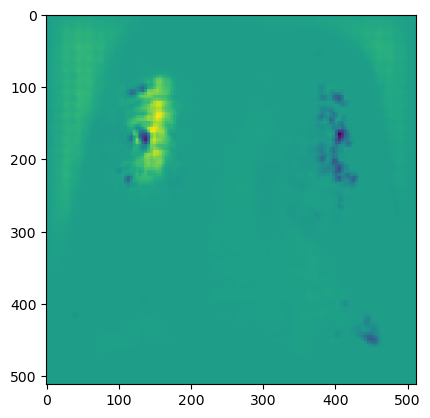

In [31]:
plt.imshow(test_attrs)

In [8]:
single_full_model=single_full_model_1.to(device)
single_full_int_model = helpers.explainability.make_int_grad_model(single_full_model)
single_full_occ_model = helpers.explainability.make_occ_int_grad_model(single_full_model)
single_full_model = single_full_model.to("cpu")

In [9]:
cv2.imwrite('occlusion_attr_test.png',convert_to_uint8(occ_attrs))

NameError: name 'occ_attrs' is not defined

In [17]:
test_mask = cv2.imread("occlusion_attr_test.png")

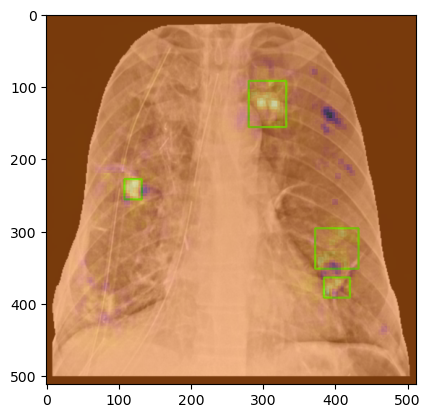

In [19]:
plt.imshow(occ_img)
plt.imshow(convert_to_uint8(occ_attrs), alpha=0.5, cmap="inferno")

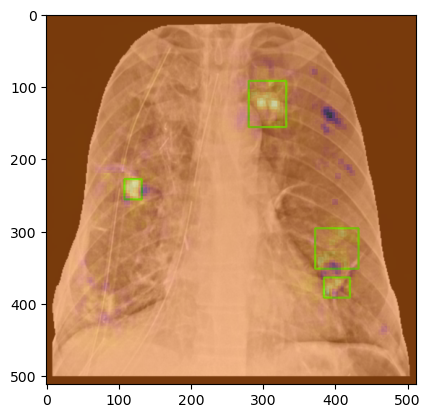

In [21]:
plt.imshow(occ_img)
plt.imshow(test_mask[:,:,0], alpha=0.5, cmap="inferno")